In [ ]:
# Copyright (c) Microsoft Corporation.
# Licensed under the MIT License.


# Custom TF model

In this tutorial we are going to create a small custom model for node classification task on [a caveman graph](http://mathworld.wolfram.com/CavemanGraph.html).
First we'll import all modules used in the tutorial and set up some global settings.

In [1]:
import random, json
from pathlib import Path
import argparse
import os
import tempfile
import networkx as nx
import numpy as np
import tensorflow as tf
from dataclasses import dataclass

from deepgnn.tf.common import utils
from deepgnn.graph_engine import FeatureType
from deepgnn.graph_engine.snark.converter.options import DataConverterType

from deepgnn import setup_default_logging_config
setup_default_logging_config()


## Data preparation

We are going to generate a random graph with 5 clusters, each cluster contains exactly 10 nodes.
Nodes are grouped together by id, i.e. first cluster contains nodes [0-9], second has [10-19], etc.

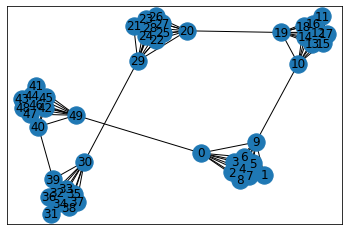

In [2]:
random.seed(246)
np.random.seed(4812)

num_clusters = 5
num_nodes_in_cluster = 10
max_node_cnt = num_clusters * num_nodes_in_cluster
g = nx.connected_caveman_graph(num_clusters, num_nodes_in_cluster)

nx.draw_networkx(g)

We need to assign some features for every node to train the model and to keep things simple we'll create a feature vector with 2 elements: 
```python
[2.5*(node_id / (num_nodes_in_cluster * num_clusters) - 0.4), random.uniform(0, 1)]. 
```

The first component component has a normalized cluster id encoded with some noise and the second component contains only noise.


Labels will be stored in the logit(one hot encoded) format as float feature with id `1`.

In [3]:
nodes = []
data = ""
for node_id in g:
    cluster_id = float(node_id // num_nodes_in_cluster)
    normalized_cluster = cluster_id / num_clusters - 0.4
    node = {
        "node_weight": 1,
        "node_id": node_id,
        "node_type": 0,
        "uint64_feature": None,
        "float_feature": {
            "0": [
                0.02 * random.uniform(0, 1) + 2.5 * normalized_cluster - 0.01,
                random.uniform(0, 1),
            ],
            "1": [1 if el == cluster_id else 0 for el in range(num_clusters)],
        },
        "binary_feature": None,
        "edge": [],
        "neighbor": {
            "0": dict(
                [(str(neighbor_id), 1.0) for neighbor_id in nx.neighbors(g, node_id)]
            )
        },
    }
    data += json.dumps(node) + "\n"
    nodes.append(node)
    
print('----print nodes[49]-----')
print(nodes[49])

----print nodes[49]-----
{'node_weight': 1, 'node_id': 49, 'node_type': 0, 'uint64_feature': None, 'float_feature': {'0': [1.0023727889837524, 0.34556286809360803], '1': [0, 0, 0, 0, 1]}, 'binary_feature': None, 'edge': [], 'neighbor': {'0': {'40': 1.0, '41': 1.0, '42': 1.0, '43': 1.0, '44': 1.0, '45': 1.0, '46': 1.0, '47': 1.0, '48': 1.0, '0': 1.0}}}


In order to start graph engine we need to create a file with metadata describing graph as a whole.

Convert json to binary format:

In [4]:
meta = '{"node_float_feature_num": 2, \
         "edge_binary_feature_num": 0, \
         "edge_type_num": 1, \
         "edge_float_feature_num": 0, \
         "node_type_num": 1, \
         "node_uint64_feature_num": 0, \
         "node_binary_feature_num": 0, \
         "edge_uint64_feature_num": 0}'


working_dir = "./graphdata"
os.makedirs(working_dir, exist_ok=True)

data_filename = os.path.join(working_dir, "data.json")
with open(data_filename, "w+") as f:
    f.write(data)
meta_filename = os.path.join(working_dir, "meta.json")
with open(meta_filename, "w+") as f:
    f.write(meta)



In [5]:
import deepgnn.graph_engine.snark.convert as convert
from deepgnn.graph_engine.snark.decoders import DecoderType
partitions = 1
convert.MultiWorkersConverter(
    graph_path=data_filename,
    meta_path=meta_filename,
    partition_count=partitions,
    output_dir=working_dir,
    decoder_type=DecoderType.JSON,
).convert()


[2022-02-15 10:08:22,567] {convert.py:200} INFO - worker 0 try to generate partition: 0 - 1
[2022-02-15 10:08:22,574] {_adl_reader.py:123} INFO - [1,0] Input files: ['./graphdata/data.json']
/home/tiantiaw/.local/lib/python3.6/site-packages/deepgnn/graph_engine/snark/alias.py:19: RuntimeWarning: invalid value encountered in true_divide
  weights = np.multiply(weights, len(weights) / np.sum(weights))


Now we can initialize the graph engine in local mode:

In [6]:
from deepgnn.graph_engine.snark.client import PartitionStorageType
from deepgnn.graph_engine.backends.snark.client import SnarkLocalBackend
args = argparse.Namespace(
    data_dir=working_dir,
    partitions=[0],
    storage_type=PartitionStorageType.memory,
    config_path="",
    stream=False,
)
ge = SnarkLocalBackend(args)

# check node features for nodeids = [0, 13, 42], feature id is `0`, length `2` 
ge.graph.node_features(
    np.array([0, 13, 42]), np.array([[0, 2]], dtype=np.int32), FeatureType.FLOAT
)

[2022-02-15 10:08:22,759] {local.py:30} INFO - Graph data path: ./graphdata. Partitions [0]
[2022-02-15 10:08:22,767] {local.py:35} INFO - Loaded snark graph. Node counts: [50]. Edge counts: [0]


array([[-0.9914585 ,  0.51667684],
       [-0.49990606,  0.8618959 ],
       [ 1.0047895 ,  0.91561705]], dtype=float32)

## Model training

Lets build a model that resembles graphsage: for every node we are going to fetch it's neighbor features and aggregate them with a mean function. `fanouts` parameter defines how many neighbors do we want to fetch for every hop and to keep things simple the model will have a single trainable matrix with shape `[len(fanouts) * feature_dim, label_dim]`.

Graph itself stores both labels and model inputs. Labels are node features with id equal to `1` and node features with `0` id will be inputs for the model.

In [7]:
class GraphQuery:
    def __init__(
        self,
        fanouts: list = [10, 10],
        label_idx: int = 0,
        label_dim: int = 5,
        feature_idx: int = 1,
        feature_dim: int = 2,
    ):
        self.fanouts = fanouts
        self.feature_dim = feature_dim
        self.label_meta = np.array([[label_idx, label_dim]])
        self.feat_meta = np.array([[feature_idx, feature_dim]])


    def query(self, graph, inputs, return_shape=False):
        """
        Query graph to fetch nodes features and labels for the inputs.
        Put them in the context to train model in the call method later.
        """
        labels = graph.node_features(inputs, self.label_meta, FeatureType.FLOAT)
        node_features = graph.node_features(inputs, self.feat_meta, FeatureType.FLOAT)

        hops = [inputs]
        features = [node_features]
        for count in self.fanouts:
            nbs = graph.sample_neighbors(
                nodes=hops[-1], edge_types=np.array([0], dtype=np.int32), count=count,
            )[0].flatten()
            hops.append(nbs)

            val = graph.node_features(nbs, self.feat_meta, FeatureType.FLOAT)

            # number of neighbors belonging to the original inputs
            middle = val.size // (len(inputs) * self.feature_dim)
            features.append(
                val.reshape(len(inputs), middle, self.feature_dim).mean(axis=1)
            )

        features = np.concatenate(features, axis=1)
        graph_tensor = tuple([inputs, features, labels])
        if return_shape:
            shapes = [list(x.shape) for x in graph_tensor]
            return graph_tensor, shapes
        else:
            return graph_tensor

In [8]:
class CustomModel(tf.keras.Model):
    def __init__(self, num_clusters):
        super().__init__(name="mymodel")
        self.num_clusters = num_clusters
        self.dense_layer = tf.keras.layers.Dense(num_clusters, use_bias=False)


    def call(self, inputs, training = True):
        """
        Generate embedings for inputs in the context and produce loss/f1 score based 
        on the context labels
        """
        nodes, features, labels = inputs
        logits = self.dense_layer(features)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
        predictions = tf.nn.softmax(logits)
        predictions = tf.one_hot(tf.argmax(predictions, axis=1), self.num_clusters)
        loss = tf.reduce_mean(loss)
        acc = self.calc_acc(labels, predictions)
        self.predictions = predictions
        self.labels = labels
        self.src = nodes
        return predictions, loss, {"acc": acc}
    
    def calc_acc(self, labels, preds):
        correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))
        accuracy_all = tf.cast(correct_prediction, tf.float32)
        return tf.reduce_mean(accuracy_all)
    
    def train_step(self, data: dict):
        """override base train_step."""
        with tf.GradientTape() as tape:
            _, loss, metrics = self(data, training=True)

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        result = {"loss": loss}
        result.update(metrics)
        return result

    def test_step(self, data: dict):
        """override base test_step."""
        _, loss, metrics = self(data, training=False)
        result = {"loss": loss}
        result.update(metrics)
        return result

    def predict_step(self, data: dict):
        """override base predict_step."""
        self(data, training=False)
        return [self.src, self.predictions]
    
    def get_prediction_label(self):
        return self.predictions, self.labels


## Create `Trainer` object
 - run `trainer.train(...)`.

In [9]:
import logging

from deepgnn.tf.common.tf2_trainer import EagerTrainer
from deepgnn.tf.common.args import TrainerType
from deepgnn import get_logger



tmp_dir = tempfile.TemporaryDirectory()
trainer = EagerTrainer(
    model_dir=tmp_dir.name,
    seed = None,
    log_save_steps = 50,
    summary_save_steps = 20,
    checkpoint_save_secs = 100,
    logger = get_logger(),
)


[2022-02-15 10:08:23,553] {base_trainer.py:42} INFO - tensorflow version: 2.5.0
[2022-02-15 10:08:23,555] {tf2_trainer.py:137} INFO - device: PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


### Start Training
1. create `sampler`
2. build model
3. run training.

In [10]:
from deepgnn.tf.common.dataset import create_tf_dataset
from deepgnn.graph_engine import GraphType, BackendType
from deepgnn.graph_engine import BackendOptions, GraphType, BackendType, GENodeSampler,RangeNodeSampler

batch_size = 16
num_epochs = 100 # One epoch represents processing all nodes in the graph.
learning_rate = 0.1

args = argparse.Namespace(
    data_dir=working_dir,
    backend=BackendType.SNARK,
    graph_type=GraphType.LOCAL,
    converter=DataConverterType.SKIP,
    graph_name="data.json",
)

model = CustomModel(num_clusters)
q = GraphQuery(
        label_idx=1,
        label_dim=num_clusters,
        feature_dim=2,
        feature_idx=0,
        fanouts=[10, 10, 5],
    )

ds = create_tf_dataset(
    sampler_class=GENodeSampler,
    query_fn=q.query,
    backend=ge,
    backend_options=BackendOptions(args),
    node_types=np.array([0], dtype=np.int32),
    batch_size=batch_size,
)[0]

trainer.train(
    dataset=ds,
    model=model,
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate),
    epochs=num_epochs,
)

[2022-02-15 10:08:23,827] {samplers.py:148} INFO - Node Count ([0]): 50
[2022-02-15 10:08:23,831] {dataset.py:33} INFO - check array shape: (16,) vs [16]
[2022-02-15 10:08:23,832] {dataset.py:33} INFO - check array shape: (16, 8) vs [16, 8]
[2022-02-15 10:08:23,833] {dataset.py:33} INFO - check array shape: (16, 5) vs [16, 5]
[2022-02-15 10:08:23,836] {dataset.py:25} INFO - numpy ((16,), int64), tf tensor ((16,), <dtype: 'int64'>)
[2022-02-15 10:08:23,837] {dataset.py:25} INFO - numpy ((16, 8), float32), tf tensor ((16, 8), <dtype: 'float32'>)
[2022-02-15 10:08:23,838] {dataset.py:25} INFO - numpy ((16, 5), float32), tf tensor ((16, 5), <dtype: 'float32'>)
[2022-02-15 10:08:23,907] {logging_utils.py:76} INFO - Training worker started.
[2022-02-15 10:08:23,909] {tf2_trainer.py:180} INFO - training num_steps/epochs: None, num_epochs: 100
[2022-02-15 10:08:25,053] {utils.py:160} INFO - --------------variables-----------
[2022-02-15 10:08:25,054] {utils.py:162} INFO - 0	mymodel/dense/kerne

## Verify model predictions
 - check `prediction`

In [11]:
args = argparse.Namespace(
    data_dir=working_dir,
    backend=BackendType.SNARK,
    graph_type=GraphType.LOCAL,
    converter=DataConverterType.LOCAL,
    graph_name="data.json",
)
ds = create_tf_dataset(
    sampler_class=RangeNodeSampler,
    query_fn=q.query,
    backend=ge,
    backend_options=BackendOptions(args),
    first=0,
    last=max_node_cnt,
    batch_size=10,
    worker_index=0,
    num_workers=1,
    backfill_id=max_node_cnt+1,
)[0]

trainer.inference(
    ds,
    model,
    embedding_to_str_fn=utils.node_embedding_to_string,
)
np.set_printoptions(formatter={"float_kind": "{: .2f}".format})
pred = utils.load_embeddings(tmp_dir.name, max_node_cnt, num_clusters)
print('----- prediction -----')
print(np.argmax(pred, 1).reshape(num_clusters, -1))


[2022-02-15 10:09:34,159] {dataset.py:33} INFO - check array shape: (10,) vs [10]
[2022-02-15 10:09:34,161] {dataset.py:33} INFO - check array shape: (10, 8) vs [10, 8]
[2022-02-15 10:09:34,163] {dataset.py:33} INFO - check array shape: (10, 5) vs [10, 5]
[2022-02-15 10:09:34,164] {dataset.py:25} INFO - numpy ((10,), int64), tf tensor ((10,), <dtype: 'int64'>)
[2022-02-15 10:09:34,165] {dataset.py:25} INFO - numpy ((10, 8), float32), tf tensor ((10, 8), <dtype: 'float32'>)
[2022-02-15 10:09:34,165] {dataset.py:25} INFO - numpy ((10, 5), float32), tf tensor ((10, 5), <dtype: 'float32'>)
[2022-02-15 10:09:34,196] {logging_utils.py:76} INFO - Training worker started.
[2022-02-15 10:09:34,197] {tf2_trainer.py:374} INFO - inference num_steps: None
[2022-02-15 10:09:34,198] {tf2_trainer.py:406} INFO - embedding file: /tmp/tmph130c5ew/./embedding_0.tsv
[2022-02-15 10:09:34,616] {utils.py:160} INFO - --------------variables-----------
[2022-02-15 10:09:34,618] {utils.py:162} INFO - 0	mymodel/d

----- prediction -----
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


In [12]:
#!tensorboard --logdir $MODEL_DIR